Reproduction of the experiment from Fig 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp

# Quantile Loss

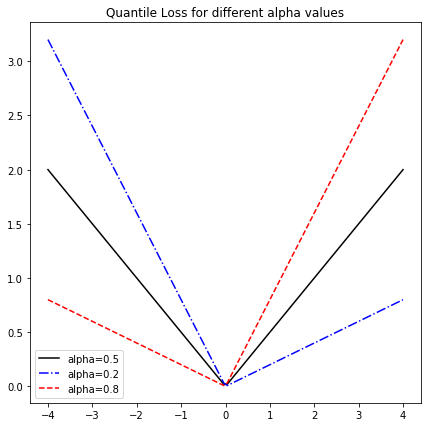

In [2]:
quantile_loss = lambda x, alpha=0.5: x*(alpha - (x<0))

plt.figure(figsize=(7,7))

x = np.linspace(-4,4,100)
plt.plot(x, quantile_loss(x), c="black", label="alpha=0.5")
plt.plot(x, quantile_loss(x,0.2), "b-.", label="alpha=0.2")
plt.plot(x, quantile_loss(x,0.8), "r--", label="alpha=0.8")

plt.title("Quantile Loss for different alpha values")

plt.legend()

plt.show()

# Generic Data

In [23]:
nsample = 40
sig = np.sqrt(0.25)

X = 2*np.random.random(nsample) - 1
e = sig*np.random.randn(nsample)
y = X + e

theoretical_quantile = lambda x,alpha=0.5,sigma=1: sigma*norm().ppf(alpha) + x

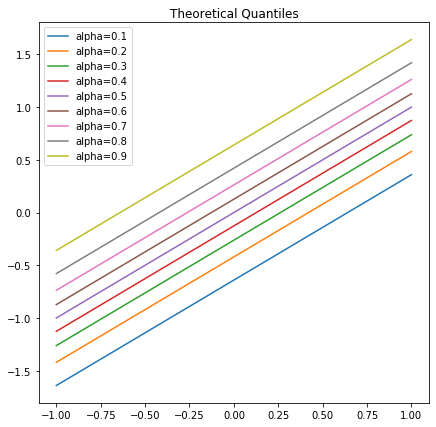

In [25]:
alpha_l = np.arange(0.1,1,0.1)
x = np.linspace(-1,1,100)

plt.figure(figsize=(7,7))

for alpha in alpha_l:
    plt.plot(x, theoretical_quantile(x,alpha,sig), label="alpha={}".format(np.round(alpha,2)))

plt.title("Theoretical Quantiles")
plt.legend()
plt.show()

# Kernel Quantile Regression


The optimal value is 2.0941371132068056

The optimal value is 3.6906220191193473

The optimal value is 5.22389824757004

The optimal value is 6.713032476238391

The optimal value is 8.158219970601355

The optimal value is 9.5772607559159

The optimal value is 10.982654461803639

The optimal value is 12.377101413540974

The optimal value is 13.761266244711877


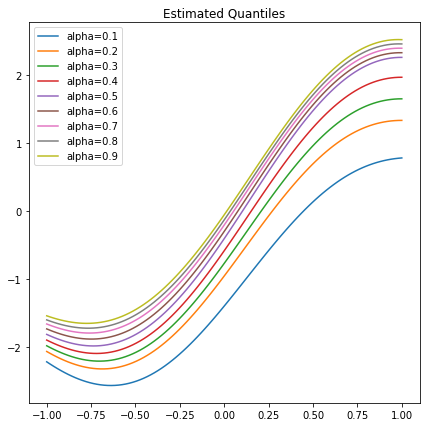

In [30]:
gauss_kernel = lambda x,y,sigma=1: np.exp(-np.sum((x-y)**2)/sigma**2)
quantile_sol = lambda x,w: np.sum([w[i]*gauss_kernel(x,X[i]) for i in range(nsample)])

sigma=0.1
lambd = 0.1

K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

alpha_l = np.arange(0.1,1,0.1)

# Generate a random non-trivial quadratic program.
n = 3*nsample
m = 4*nsample

#np.random.seed(1)

P = np.zeros((n,n))
P[0:nsample,0:nsample] = K

G = np.zeros((m,n))
G[0:nsample,nsample:2*nsample] = -np.eye(nsample)
G[nsample:2*nsample,2*nsample:3*nsample] = -np.eye(nsample)
G[2*nsample:3*nsample,0:nsample] = -K
G[2*nsample:3*nsample,nsample:2*nsample] = -np.eye(nsample)
G[3*nsample:4*nsample,0:nsample] = K
G[3*nsample:4*nsample,2*nsample:3*nsample] = np.eye(nsample)

h = np.zeros(m)
h[2*nsample:3*nsample] = -y
h[3*nsample:4*nsample] = y

abscisse = np.linspace(-1,1,100)
plt.figure(figsize=(7,7))

for alpha in alpha_l:

    q = np.zeros(n)
    q[nsample:2*nsample] = alpha
    q[2*nsample:3*nsample] = 1-alpha

    # Define and solve the CVXPY problem.
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(lambd*0.5*cp.quad_form(x, P) + q.T @ x),
                     [G @ x <= h])
    prob.solve()

    # Print result.
    print("\nThe optimal value is", prob.value)
    #print("A solution x is")
    #print(x.value)
    #print("A dual solution corresponding to the inequality constraints is")
    #print(prob.constraints[0].dual_value)
    
    w_opt = x.value[:nsample]
    
    t = [quantile_sol(xi,w_opt) for xi in abscisse]
    plt.plot(abscisse, t, label="alpha={}".format(np.round(alpha,2)))
    
    
plt.title("Estimated Quantiles")
plt.legend()
plt.show()

Cela a l'air de tres marcher, attention a la dependance sur les hyperparametres cependant. Intercept ???

# Simultaneous Multiple Kernel Quantile Regression

Scaling is really bad with this method, linear dependence in n, dimension of the quadratic problem is: $$\mathcal{O}(pn,pn)$$

Look at complexity of interior point methods. 

In [31]:
# Hyperpatameters
sigma=0.1 # scaling Gaussian Kernel
lambd = 0.1 # regularisation strength
alpha_l = np.arange(0.1,1,0.1) # list of quantiles to estimate
p = len(alpha_l) # number of simultaneously estimated quantiles

# Feed Gaussian Kernel
K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

In [ ]:
# np.random.seed(1)

# QP Dimension
n = 3*p*nsample 
m = (p-1)*nsample + 4*p*nsample

############## Variables to solve QP ##########################
P = np.zeros((n,n))
for k in range(p):
    P[k*nsample:(k+1)*nsample,k*nsample:(k+1)*nsample] = K

#for k in range(p):
    #q[p+2*k*nsample:p+(2*k+1)*nsample] = alpha
    #q[p+(2*k+1)*nsample:p+2*(k+1)*nsample] = 1-alpha
q = np.zeros(n)
for k in range(p):
    q[p*nsample+k*nsample:p*nsample+(k+1)*nsample] = alpha_l[k]
    q[2*p*nsample+k*nsample:2*p*nsample + (k+1)*nsample] = 1-alpha_l[k]
    
h = np.zeros(m)
h[(p-1)*nsample + 2*p*nsample:(p-1)*nsample + 3*p*nsample] = -y
h[(p-1)*nsample + 3*p*nsample:(p-1)*nsample + 4*p*nsample] = y

    
G = np.zeros((m,n))
G[0:nsample,nsample:2*nsample] = -np.eye(nsample)
G[nsample:2*nsample,2*nsample:3*nsample] = -np.eye(nsample)
G[2*nsample:3*nsample,0:nsample] = -K
G[2*nsample:3*nsample,nsample:2*nsample] = -np.eye(nsample)
G[3*nsample:4*nsample,0:nsample] = K
G[3*nsample:4*nsample,2*nsample:3*nsample] = np.eye(nsample)
##############################################################

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(lambd*0.5*cp.quad_form(x, P) + q.T @ x),[G @ x <= h])
prob.solve()
print("\nThe optimal value is", prob.value)
# Optimal weight:
w_opt = x.value[:nsample]

# Plot results 
abscisse = np.linspace(-1,1,100)
plt.figure(figsize=(7,7))

t = [quantile_sol(xi,w_opt) for xi in abscisse]
plt.plot(abscisse, t, label="alpha={}".format(np.round(alpha,2)))
    
plt.title("Estimated Quantiles (multi-task)")
plt.legend()
plt.show()